In [1]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print("Memoria total:", torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")
    print("Memoria usada:", torch.cuda.memory_allocated() / 1024**3, "GB")
    print("Memoria reservada:", torch.cuda.memory_reserved() / 1024**3, "GB")
else:
    print("CUDA no disponible.")


NVIDIA GeForce RTX 4070 Ti SUPER
Memoria total: 15.99169921875 GB
Memoria usada: 0.0 GB
Memoria reservada: 0.0 GB


In [3]:
def get_input_size(model_name: str):
    """
    Retorna el tamaño de entrada esperado por el modelo.
    """
    name = model_name.lower()
    if name in [
        'vgg16', 'resnet50', 'densenet121',
        'mobilenet_v2', 'googlenet', 'efficientnet_b0'
    ]:
        return (224, 224)
    elif name == 'inception_v3':
        return (299, 299)
    else:
        return (224, 224)  # valor por defecto

In [4]:
def get_model(model_name: str, num_classes: int):
    """
    Carga y retorna un modelo preentrenado con la última capa ajustada a 'num_classes'.
    """
    name = model_name.lower()

    # ResNet50
    if name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    # VGG16
    elif name == 'vgg16':
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(4096, num_classes)

    # DenseNet121
    elif name == 'densenet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    # MobileNet v2
    elif name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    # EfficientNet b0
    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    # Inception v3
    elif name == 'inception_v3':
        model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    # GoogLeNet
    elif name == 'googlenet':
        model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT, aux_logits=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    else:
        raise NotImplementedError(f"Modelo '{model_name}' no está implementado.")

    return model

In [5]:
def get_dataloaders(
    data_dir: str, 
    model_name: str, 
    batch_size: int, 
    train_fraction: float = 0.8, 
    val_fraction: float = 0.1, 
    test_fraction: float = 0.1
):
    """
    Crea DataLoaders para entrenamiento, validación y test a partir de las imágenes en 'data_dir'.
    
    Por defecto:
      - train_fraction = 0.8 (80%)
      - val_fraction   = 0.1 (10%)
      - test_fraction  = 0.1 (10%)

    Se asume que train_fraction + val_fraction + test_fraction = 1.0
    """
    # Verificamos que la suma sea 1.0 (o muy cercana, por ejemplo 0.9999...1.0001)
    total = train_fraction + val_fraction + test_fraction
    assert abs(total - 1.0) < 1e-8, "La suma de train, val y test fractions debe ser 1.0."

    input_size = get_input_size(model_name)

    # Transformaciones de entrada
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Dataset completo
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(dataset)
    num_classes = len(dataset.classes)

    # Calcular tamaños
    train_size = int(num_samples * train_fraction)
    val_size = int(num_samples * val_fraction)
    test_size = num_samples - train_size - val_size  # lo que quede

    # Split: train, val, test
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    # DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    return train_loader, val_loader, test_loader, num_classes


In [6]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Evalúa el modelo en un dataloader (por ejemplo, test_loader)
    y retorna la pérdida y accuracy.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    total_samples = len(dataloader.dataset)
    final_loss = running_loss / total_samples
    final_acc = running_corrects.double() / total_samples

    return final_loss, final_acc.item()

In [7]:
def train_model(
    model_name: str,
    data_dir: str,
    batch_size: int = 32,
    num_epochs: int = 30,
    lr: float = 1e-4,
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
    test_fraction: float = 0.1,
    device: str = None
):
    """
    Función principal para entrenar un modelo con triple partición (train, val, test):
      - Carga los DataLoaders
      - Construye el modelo
      - Realiza entrenamiento (train) y validación (val)
      - Finalmente evalúa en test
      - Retorna el modelo entrenado y un historial de métricas para graficar
    """
    # Seleccionar dispositivo
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device}")

    # 1) Obtener DataLoaders y número de clases
    train_loader, val_loader, test_loader, num_classes = get_dataloaders(
        data_dir=data_dir,
        model_name=model_name,
        batch_size=batch_size,
        train_fraction=train_fraction,
        val_fraction=val_fraction,
        test_fraction=test_fraction
    )

    # 2) Construir modelo
    model = get_model(model_name, num_classes).to(device)

    # 3) Definir criterio de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Para llevar registro del historial
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n📦 Epoch {epoch+1}/{num_epochs}")
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(dataloader, desc=f"{phase.capitalize()} Phase")
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)

                # Habilitar/Deshabilitar gradientes según la fase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Acumular métricas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            # Guardar el mejor modelo en función de la val_acc
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f"\n✅ Mejor accuracy en validación: {best_acc:.4f}")

    # Cargar mejores pesos
    model.load_state_dict(best_model_wts)

    # 4) Guardar modelo entrenado
    save_name = f"{model_name}_best_parallel.pth"
    torch.save(model.state_dict(), save_name)
    print(f"Modelo guardado como: {save_name}")

    # 5) Evaluar en el conjunto de test
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"\n=== Evaluación en Test ===\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Retornamos el modelo y la historia de entrenamiento
    return model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [8]:
def plot_training_curves(train_loss, train_acc, val_loss, val_acc):
    """
    Crea dos gráficas:
    1. Pérdida (loss) vs. época para train y val
    2. Exactitud (accuracy) vs. época para train y val
    """
    epochs = range(1, len(train_loss) + 1)

    # Gráfico de pérdida
    plt.figure()
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.show()

    # Gráfico de exactitud
    plt.figure()
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.show()

Usando dispositivo: cuda

📦 Epoch 1/10


Train Phase: 100%|██████████| 175/175 [01:24<00:00,  2.08it/s]


train Loss: 0.1171 | Acc: 0.9766


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.91it/s]


val Loss: 0.0322 | Acc: 0.9943

📦 Epoch 2/10


Train Phase: 100%|██████████| 175/175 [01:23<00:00,  2.10it/s]


train Loss: 0.0357 | Acc: 0.9910


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.90it/s]


val Loss: 0.0296 | Acc: 0.9950

📦 Epoch 3/10


Train Phase: 100%|██████████| 175/175 [01:21<00:00,  2.14it/s]


train Loss: 0.0286 | Acc: 0.9926


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.97it/s]


val Loss: 0.0378 | Acc: 0.9957

📦 Epoch 4/10


Train Phase: 100%|██████████| 175/175 [01:22<00:00,  2.13it/s]


train Loss: 0.0120 | Acc: 0.9961


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.97it/s]


val Loss: 0.0365 | Acc: 0.9957

📦 Epoch 5/10


Train Phase: 100%|██████████| 175/175 [01:23<00:00,  2.10it/s]


train Loss: 0.0053 | Acc: 0.9983


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.95it/s]


val Loss: 0.0445 | Acc: 0.9957

📦 Epoch 6/10


Train Phase: 100%|██████████| 175/175 [01:22<00:00,  2.12it/s]


train Loss: 0.0077 | Acc: 0.9969


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.93it/s]


val Loss: 0.0379 | Acc: 0.9957

📦 Epoch 7/10


Train Phase: 100%|██████████| 175/175 [01:23<00:00,  2.09it/s]


train Loss: 0.0019 | Acc: 0.9999


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.85it/s]


val Loss: 0.0460 | Acc: 0.9957

📦 Epoch 8/10


Train Phase: 100%|██████████| 175/175 [01:27<00:00,  2.01it/s]


train Loss: 0.0007 | Acc: 0.9999


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.86it/s]


val Loss: 0.0476 | Acc: 0.9957

📦 Epoch 9/10


Train Phase: 100%|██████████| 175/175 [01:24<00:00,  2.07it/s]


train Loss: 0.0005 | Acc: 0.9999


Val Phase: 100%|██████████| 22/22 [00:11<00:00,  1.94it/s]


val Loss: 0.0445 | Acc: 0.9957

📦 Epoch 10/10


Train Phase: 100%|██████████| 175/175 [01:20<00:00,  2.16it/s]


train Loss: 0.0013 | Acc: 0.9996


Val Phase: 100%|██████████| 22/22 [00:10<00:00,  2.02it/s]


val Loss: 0.0452 | Acc: 0.9943

✅ Mejor accuracy en validación: 0.9957
Modelo guardado como: mobilenet_v2_best_parallel.pth

=== Evaluación en Test ===
Test Loss: 0.0339 | Test Acc: 0.9935


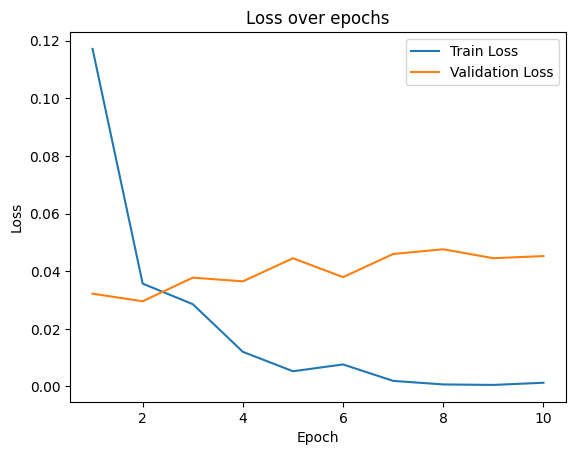

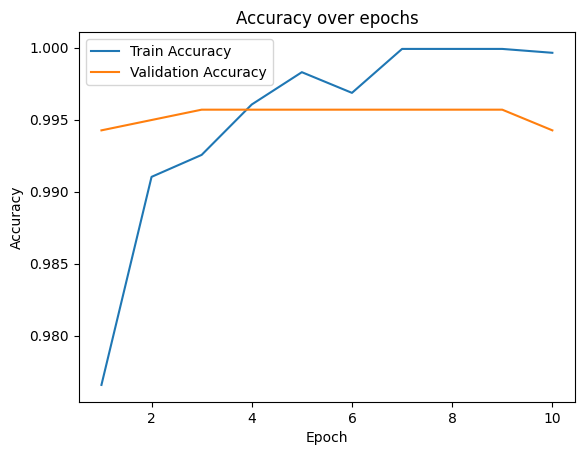

In [9]:
# Parámetros de ejemplo
MODEL_NAME = "mobilenet_v2"
DATA_DIR = "/home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/a_org"
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 2e-4

# Queremos 80% train, 10% val, 10% test
TRAIN_FRACTION = 0.8
VAL_FRACTION = 0.1
TEST_FRACTION = 0.1

# Entrenar modelo
trained_model, history = train_model(
    model_name=MODEL_NAME,
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    lr=LR,
    train_fraction=TRAIN_FRACTION,
    val_fraction=VAL_FRACTION,
    test_fraction=TEST_FRACTION,
    device='cuda'
)

# Desempaquetar historia
train_loss_history, train_acc_history, val_loss_history, val_acc_history = history

# Graficar
plot_training_curves(
    train_loss=train_loss_history,
    train_acc=train_acc_history,
    val_loss=val_loss_history,
    val_acc=val_acc_history
)